# CHAPTER 5. 순환신경망(RNN)

**피드포워드**
- 흐름이 단방향인 신경망
- 구성이 단순하여 구조를 이해하기 쉽고, 많은 문제에 응용할 수 있음
- 시계열 데이터를 잘 다루지 못함

**순환 신경망(RNN)**의 등장!

### 5.1 확률과 언어 모델

- CBOW모델: 맥락의 단어로부터 타깃 단어를 추측함

#### 언어모델

단어 나열에 확률 부여, 특정한 단어의 시퀀스에 대해서 그 시퀀스가 일어날 가능성이 어느정도인지를 확률로 평가

### 5.2 RNN이란

#### 순환하는 신경망

- 순환하는 경로(닫힌 경로) 가 있어 데이터는 끊임없이 순환함

![1](https://media.vlpt.us/post-images/dscwinterstudy/82a3d7f0-4a7b-11ea-a20b-1d8481a30fba/fig-5-8.png)

- 순환 구조를 펼친 후의 RNN에서는 (일반적인) 오차 역전파법을 적용할 수 있음, 이를 **BPTT**라고 함

#### Truncated BPTT

- 시간축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망 여러개를 만드는 아이디어

![2](https://media.vlpt.us/post-images/dscwinterstudy/b4c30ab0-4a7d-11ea-b495-e1bb7f929adb/fig-5-14.png)

이처럼 데이터를 순서대로 입력해 학습

#### Truncated BPTT의 미니배치 학습

원래대로면 구체적인 배치 방식을 고려해 데이터를 순서대로 입력! ( 그렇게 하려면 데이터를 주는 시작위치를 각 미니배치의 시작위치로 옮겨줘야 함)

![3](https://media.vlpt.us/post-images/dscwinterstudy/61115260-4b30-11ea-b709-6773af988252/fig-5-15.png)

### 5.3 RNN 구현

**TIME RNN 계층**
- T개 단계분의 작업을 한꺼번에 처리하는 계층

![4](https://media.vlpt.us/post-images/dscwinterstudy/99936490-4a89-11ea-a2aa-718777932773/fig-5-20.png)

![5](https://media.vlpt.us/post-images/dscwinterstudy/6a1c18f0-4a8a-11ea-9430-5be3dd9c226a/fig-5-22.png)

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next
    
### 역전파 구현 ###
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


### 5.4 시계열 데이터의 처리 계층 구현

#### RNNLM

- RNN을 사용한 언어 모델
- Embedding: 단어 ID를 단어의 분산 표현(단어 벡터)으로 변환
- RNN계층: 은닉 상태를 다음 층으로(위쪽으로) 출력함과 동시에 다음 시각의 RNN 계층으로(오른쪽으로) 출력<br>

![6](https://media.vlpt.us/post-images/dscwinterstudy/fefe6330-4a8d-11ea-9653-e94c08fd7d97/fig-5-25.png)

RNN계층이 위로 출력한 은닉 상태는 Affine 계층을 거쳐 Softmax계층으로 전해진다.

RNNLM은 지금까지 입력된 단어를 '기억'하고 그것을 바탕으로 다음에 출현할 단어를 예측한다. RNN계층이 과거에서 현재로 데이터를 계속 흘려보내줌으로써 과거의 정보를 인코딩해 저장(기억) 할 수 있다.

#### TIME 계층 구현

시계열 버전의 Softmax계층을 구현할 때는 손실 오차를 구하는 Cross Entropy Error 계층도 함께 구현

![7](https://media.vlpt.us/post-images/dscwinterstudy/5fcb9e20-4a8f-11ea-8410-67d4c44a3bd6/fig-5-29.png)

T개의 Softmax with Loss 계층 각각이 손실을 산출하고 그 손실들을 합산해 평균한 값이 최종 손실이 됨


### 5.5 RNNLM의 학습과 평가


In [3]:
##RNNLM 구현

import sys
sys.path.append("C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-master")
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


#### 언어 모델의 평가

언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력한다. 이때 언어 모델의 예측 성능을 평가하는 척도로 혼란도(perplexity)를 자주 이용함.

- 혼란도(perplexity) : 간단히 말하면 '확률의 역수'이다.(데이터 수가 하나일 때에 정확히 일치) 작을수록 좋은 값이다.
- 분기수(number of branches): 다음에 취할 수 있는 선택사항의 수(다음에 출현할 수 있는 단어의 후보 수)

e.g)<br>
분기수가 1.25 -> 다음에 출현할 수 있는 단어의 후보를 1개 정도로 좁혔다(좋은 모델)<br>
분기수가 5 -> 후보가 아직 5개(나쁜 모델)

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 406.43
| 에폭 2 | 퍼플렉서티 310.85
| 에폭 3 | 퍼플렉서티 233.57
| 에폭 4 | 퍼플렉서티 220.41
| 에폭 5 | 퍼플렉서티 208.87
| 에폭 6 | 퍼플렉서티 204.74
| 에폭 7 | 퍼플렉서티 200.33
| 에폭 8 | 퍼플렉서티 198.54
| 에폭 9 | 퍼플렉서티 193.14
| 에폭 10 | 퍼플렉서티 194.01
| 에폭 11 | 퍼플렉서티 189.46
| 에폭 12 | 퍼플렉서티 192.54
| 에폭 13 | 퍼플렉서티 190.15
| 에폭 14 | 퍼플렉서티 191.08
| 에폭 15 | 퍼플렉서티 190.07
| 에폭 16 | 퍼플렉서티 186.29
| 에폭 17 | 퍼플렉서티 183.51
| 에폭 18 | 퍼플렉서티 180.97
| 에폭 19 | 퍼플렉서티 182.35
| 에폭 20 | 퍼플렉서티 182.79
| 에폭 21 | 퍼플렉서티 180.65
| 에폭 22 | 퍼플렉서티 175.92
| 에폭 23 | 퍼플렉서티 173.51
| 에폭 24 | 퍼플렉서티 176.06
| 에폭 25 | 퍼플렉서티 171.46
| 에폭 26 | 퍼플렉서티 170.74
| 에폭 27 | 퍼플렉서티 164.61
| 에폭 28 | 퍼플렉서티 164.22
| 에폭 29 | 퍼플렉서티 161.06
| 에폭 30 | 퍼플렉서티 153.94
| 에폭 31 | 퍼플렉서티 155.26
| 에폭 32 | 퍼플렉서티 148.61
| 에폭 33 | 퍼플렉서티 148.43
| 에폭 34 | 퍼플렉서티 143.14
| 에폭 35 | 퍼플렉서티 140.18
| 에폭 36 | 퍼플렉서티 134.01
| 에폭 37 | 퍼플렉서티 128.43
| 에폭 38 | 퍼플렉서티 125.24
| 에폭 39 | 퍼플렉서티 120.58
| 에폭 40 | 퍼플렉서티 115.74
| 에폭 41 | 퍼플렉서티 113.34
| 에폭 42 | 퍼플렉서티 106.45
| 에폭 43 | 퍼플렉서티 100

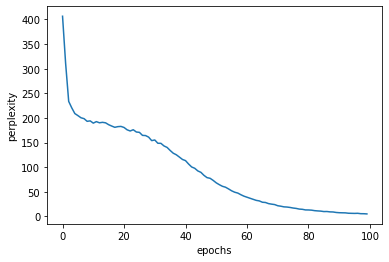

In [6]:
## 학습 코드

import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 416.55
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 369.53
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 251.88
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 220.22
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.14
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.64
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.89
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 201.01
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 196.16
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.32
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.08
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.80
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 194.09
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.89
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.40
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.08
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.72
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 186.53
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 183.32
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 184.12
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 181.06
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from c

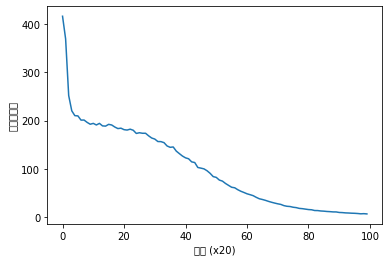

In [7]:
## RNNLM의 Trainer 클래스

from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from ch05.simple_rnnlm import SimpleRnnlm


# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()


1. 미니배치를 '순차적'으로 만들어
2. 모델의 순전파와 역전파를 호출하고
3. 옵티마이저로 가중치를 갱신하고
4. 퍼플렉서티를 구합니다 

### 5.6 정리

- RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다.
- RNN은 순환 경로를 펼침으로서 다수의 RNN 계층이 연결된 신경망으로 해석 할 수 있으며, 보통의 오차역전파법으로 학습할 수 있다(=BPTT)
- 긴 시계열 데이터를 학습할때는 데이터를 적당한 길이씩 모으고('블록'), 블록 단위로 BPTT에 의한 학습을 수행한다(=Truncated BPTT)
- Truncated BPTT에서는 역전파의 연결만 끊는다.
- Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적으로'입력해야 한다
- 언어모델은 단어 시퀀스를 확률로 해석한다
- RNN 계층을 이용한 조건부 언어모델은 (이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다